<center><h1>1-cd: Convolutional Neural Networks (ConvNets)</h1></center>

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


In [1]:
#!git clone https://github.com/cdancette/deep-learning-polytech-tp6-7.git
! wget https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py

--2023-10-17 18:26:30--  https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py [following]
--2023-10-17 18:26:31--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2627 (2.6K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.57K  --.-KB/s    in 0s      

2023-10-17 18:26:31 (35.4 MB/s) - ‘utils.py’ saved [2627/2627]



In [2]:
%run 'utils.py'

In [3]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from utils import *

PRINT_INTERVAL = 200
PATH="datasets"

In [53]:
class CIFAR10_ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(CIFAR10_ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),

            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),

            nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0)
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output



def get_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Print summary
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}

    # define model, loss, optim
    model = CIFAR10_ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)


Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/782]	Time 0.437s (0.437s)	Loss 2.3040 (2.3040)	Prec@1   9.4 (  9.4)	Prec@5  48.4 ( 48.4)


<Figure size 640x480 with 0 Axes>

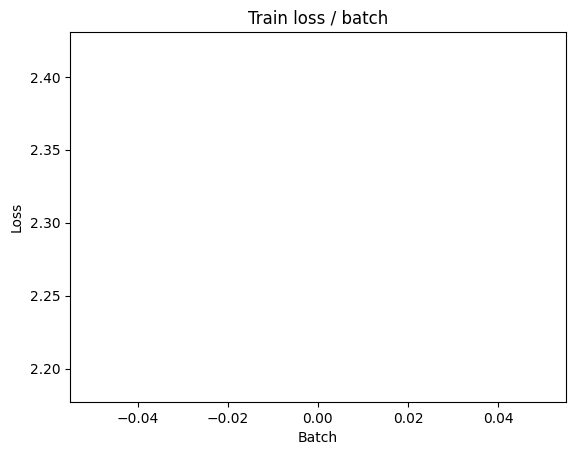

[TRAIN Batch 200/782]	Time 0.014s (0.018s)	Loss 2.0982 (2.2342)	Prec@1  32.8 ( 16.5)	Prec@5  79.7 ( 63.3)


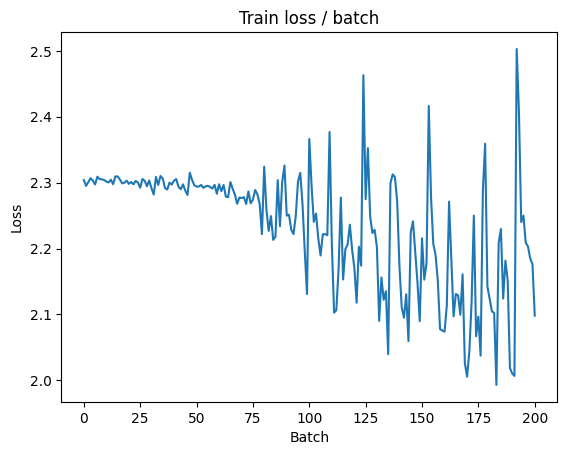

[TRAIN Batch 400/782]	Time 0.005s (0.016s)	Loss 1.7623 (2.1043)	Prec@1  35.9 ( 22.3)	Prec@5  84.4 ( 71.4)


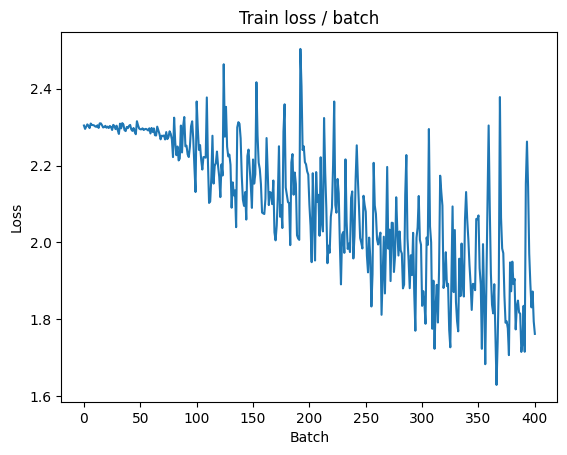

[TRAIN Batch 600/782]	Time 0.021s (0.016s)	Loss 1.9246 (1.9858)	Prec@1  34.4 ( 27.4)	Prec@5  85.9 ( 76.6)


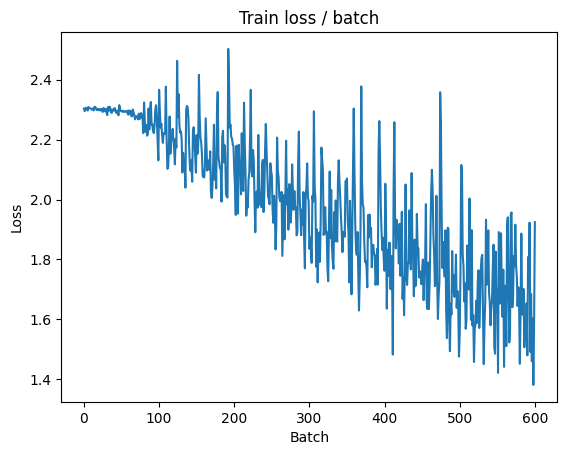


===============> Total time 12s	Avg loss 1.8944	Avg Prec@1 30.87 %	Avg Prec@5 79.78 %

[EVAL Batch 000/157]	Time 0.126s (0.126s)	Loss 1.7397 (1.7397)	Prec@1  35.9 ( 35.9)	Prec@5  89.1 ( 89.1)

===============> Total time 3s	Avg loss 1.7850	Avg Prec@1 34.60 %	Avg Prec@5 89.91 %



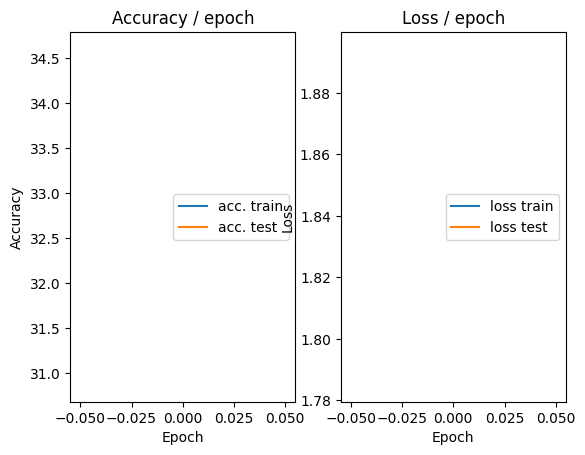

=== EPOCH 2 =====

[TRAIN Batch 000/782]	Time 0.120s (0.120s)	Loss 1.7374 (1.7374)	Prec@1  34.4 ( 34.4)	Prec@5  89.1 ( 89.1)


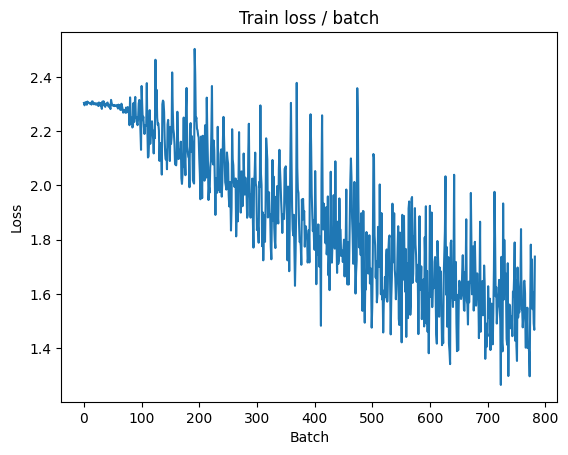

[TRAIN Batch 200/782]	Time 0.013s (0.015s)	Loss 1.2554 (1.4801)	Prec@1  48.4 ( 47.2)	Prec@5  96.9 ( 91.6)


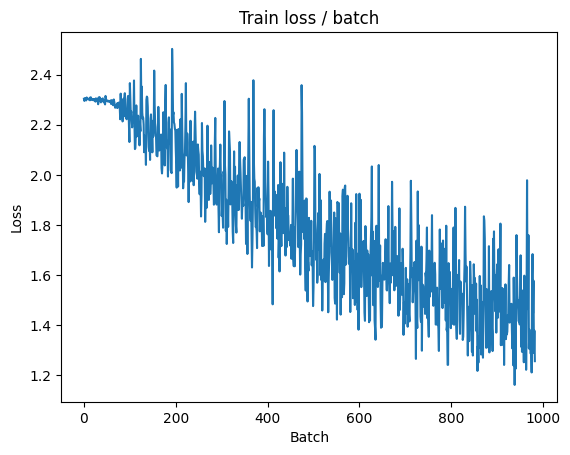

[TRAIN Batch 400/782]	Time 0.009s (0.015s)	Loss 1.3872 (1.4360)	Prec@1  50.0 ( 48.7)	Prec@5  90.6 ( 92.4)


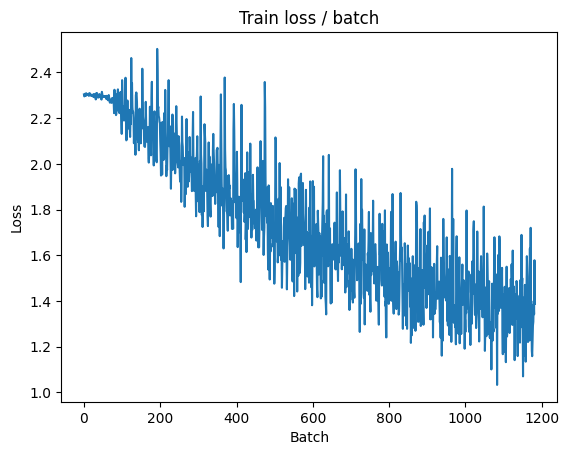

[TRAIN Batch 600/782]	Time 0.005s (0.016s)	Loss 1.6459 (1.4015)	Prec@1  40.6 ( 49.8)	Prec@5  90.6 ( 92.8)


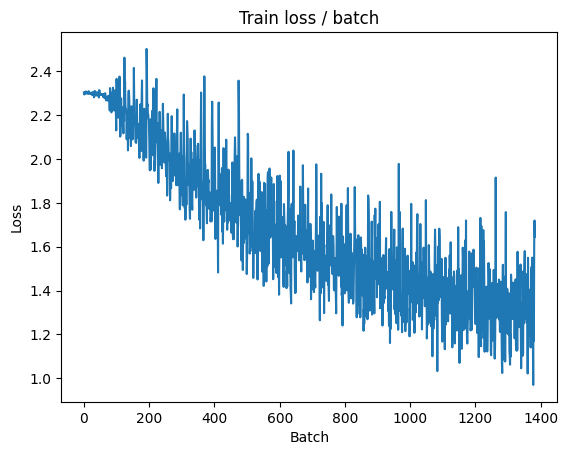


===============> Total time 12s	Avg loss 1.3701	Avg Prec@1 50.97 %	Avg Prec@5 93.23 %

[EVAL Batch 000/157]	Time 0.099s (0.099s)	Loss 1.7507 (1.7507)	Prec@1  42.2 ( 42.2)	Prec@5  93.8 ( 93.8)

===============> Total time 1s	Avg loss 1.7596	Avg Prec@1 40.78 %	Avg Prec@5 91.45 %



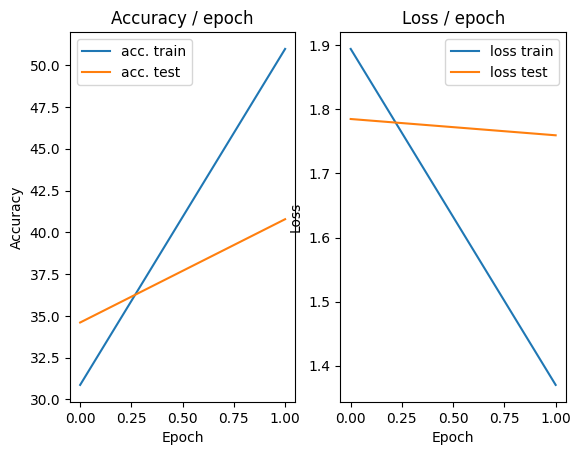

=== EPOCH 3 =====

[TRAIN Batch 000/782]	Time 0.143s (0.143s)	Loss 1.7287 (1.7287)	Prec@1  46.9 ( 46.9)	Prec@5  90.6 ( 90.6)


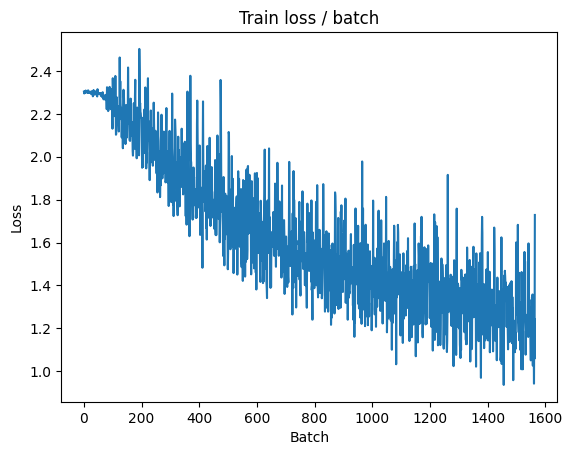

[TRAIN Batch 200/782]	Time 0.012s (0.015s)	Loss 1.0372 (1.1732)	Prec@1  64.1 ( 58.2)	Prec@5  96.9 ( 95.6)


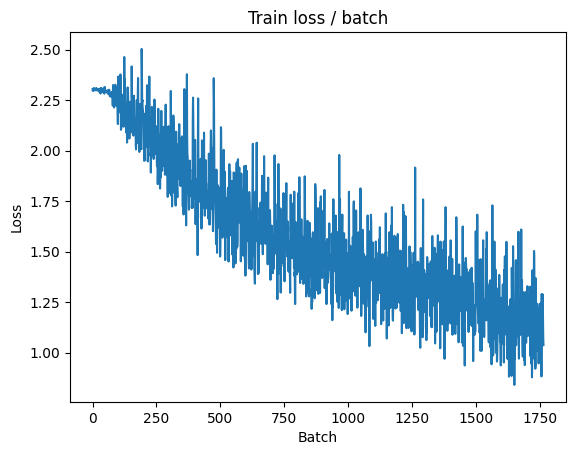

[TRAIN Batch 400/782]	Time 0.013s (0.016s)	Loss 0.9624 (1.1571)	Prec@1  57.8 ( 58.5)	Prec@5  98.4 ( 95.7)


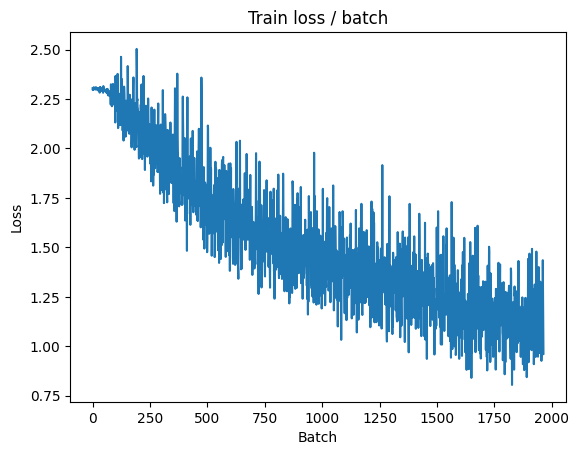

[TRAIN Batch 600/782]	Time 0.009s (0.018s)	Loss 1.1866 (1.1414)	Prec@1  53.1 ( 59.3)	Prec@5  95.3 ( 95.7)


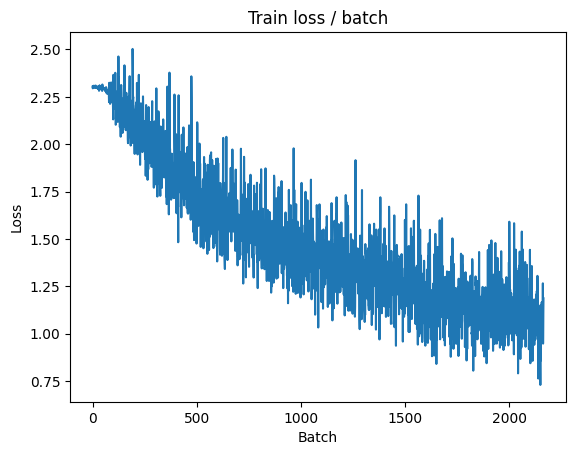


===============> Total time 13s	Avg loss 1.1270	Avg Prec@1 59.82 %	Avg Prec@5 95.82 %

[EVAL Batch 000/157]	Time 0.102s (0.102s)	Loss 1.1938 (1.1938)	Prec@1  53.1 ( 53.1)	Prec@5  92.2 ( 92.2)

===============> Total time 1s	Avg loss 1.2454	Avg Prec@1 56.26 %	Avg Prec@5 95.05 %



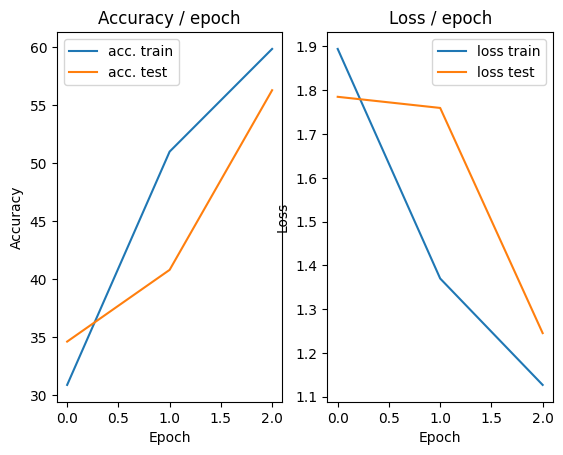

=== EPOCH 4 =====

[TRAIN Batch 000/782]	Time 0.122s (0.122s)	Loss 1.2343 (1.2343)	Prec@1  57.8 ( 57.8)	Prec@5  98.4 ( 98.4)


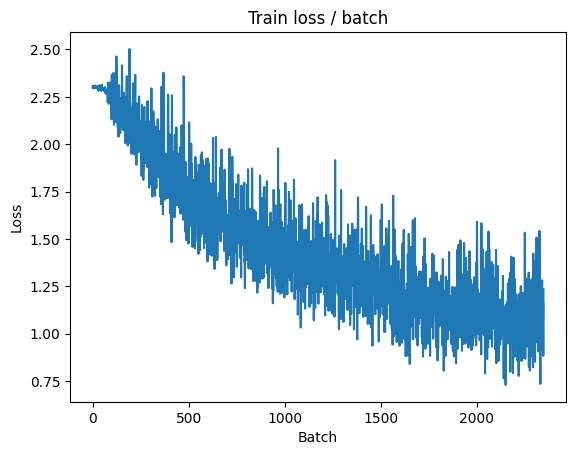

[TRAIN Batch 200/782]	Time 0.034s (0.017s)	Loss 0.9112 (0.9758)	Prec@1  67.2 ( 66.3)	Prec@5  96.9 ( 97.0)


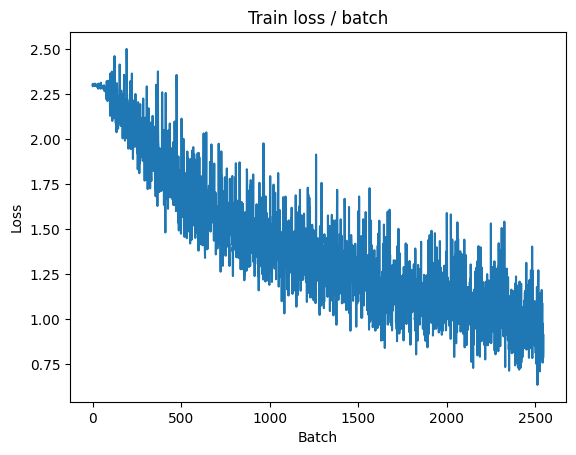

[TRAIN Batch 400/782]	Time 0.015s (0.018s)	Loss 1.0231 (0.9688)	Prec@1  64.1 ( 66.2)	Prec@5  93.8 ( 97.0)


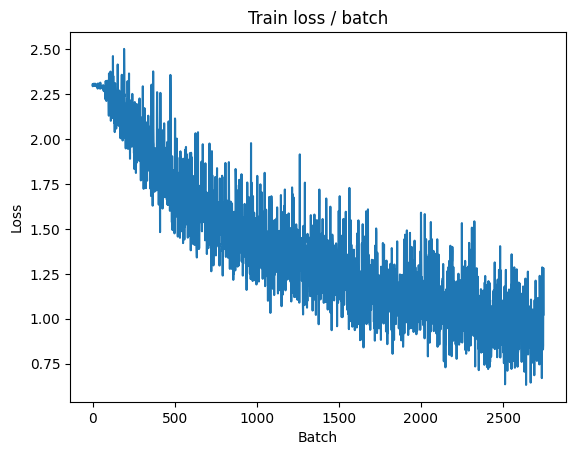

[TRAIN Batch 600/782]	Time 0.005s (0.017s)	Loss 0.9515 (0.9562)	Prec@1  73.4 ( 66.5)	Prec@5  96.9 ( 97.1)


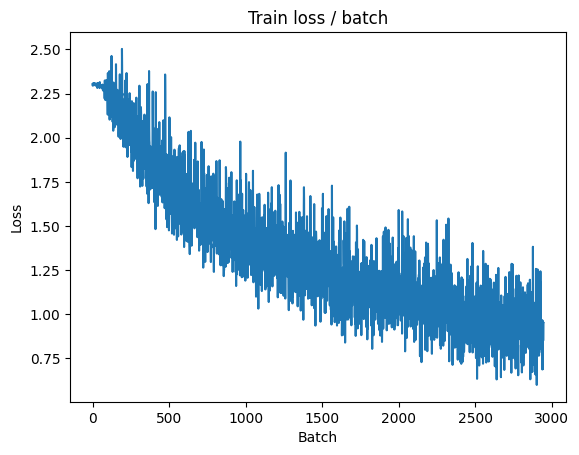


===============> Total time 12s	Avg loss 0.9475	Avg Prec@1 66.83 %	Avg Prec@5 97.14 %

[EVAL Batch 000/157]	Time 0.113s (0.113s)	Loss 1.1725 (1.1725)	Prec@1  57.8 ( 57.8)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.3211	Avg Prec@1 55.70 %	Avg Prec@5 93.78 %



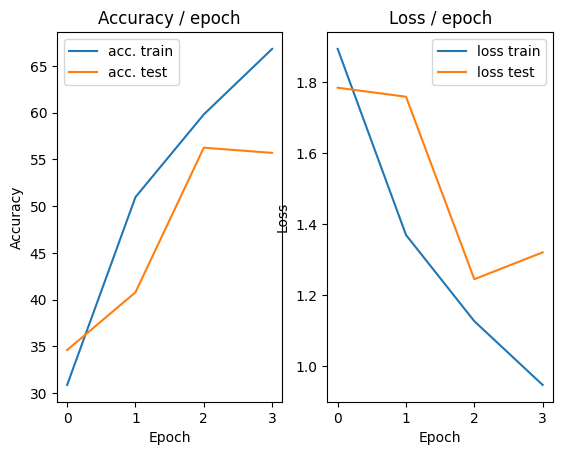

=== EPOCH 5 =====

[TRAIN Batch 000/782]	Time 0.152s (0.152s)	Loss 1.2233 (1.2233)	Prec@1  65.6 ( 65.6)	Prec@5  95.3 ( 95.3)


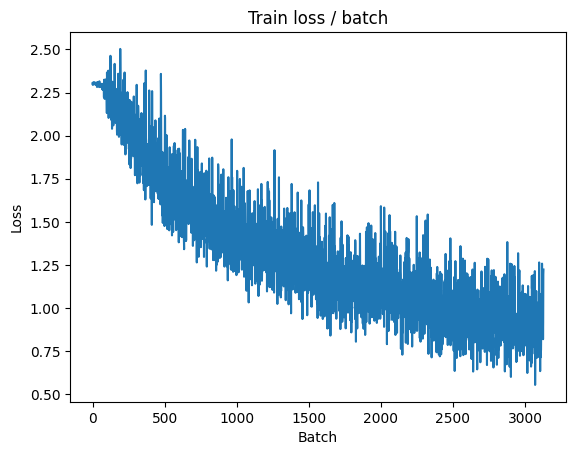

[TRAIN Batch 200/782]	Time 0.008s (0.021s)	Loss 0.9505 (0.8175)	Prec@1  68.8 ( 71.8)	Prec@5  96.9 ( 98.1)


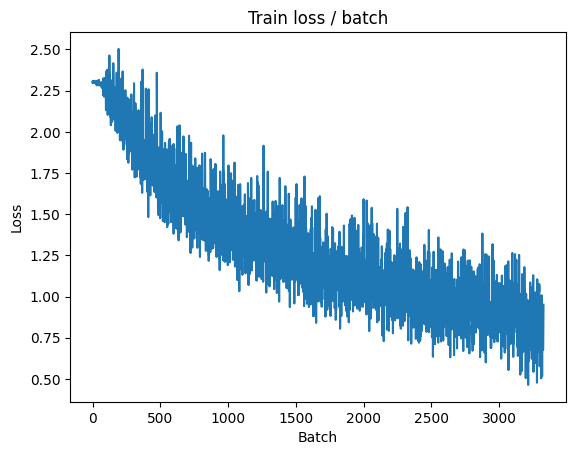

[TRAIN Batch 400/782]	Time 0.006s (0.018s)	Loss 0.7219 (0.8047)	Prec@1  75.0 ( 71.9)	Prec@5  98.4 ( 98.1)


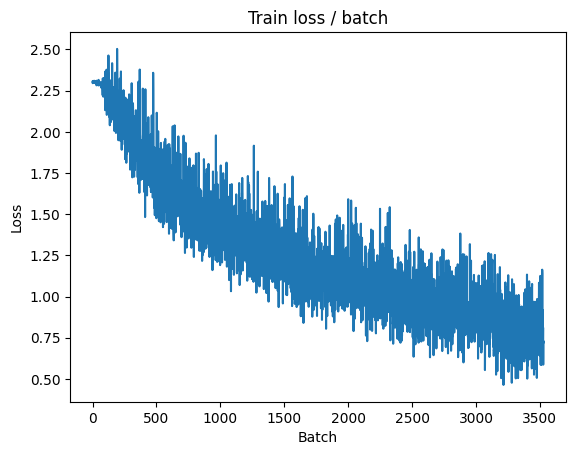

[TRAIN Batch 600/782]	Time 0.006s (0.017s)	Loss 1.0450 (0.8038)	Prec@1  73.4 ( 72.0)	Prec@5  89.1 ( 98.0)


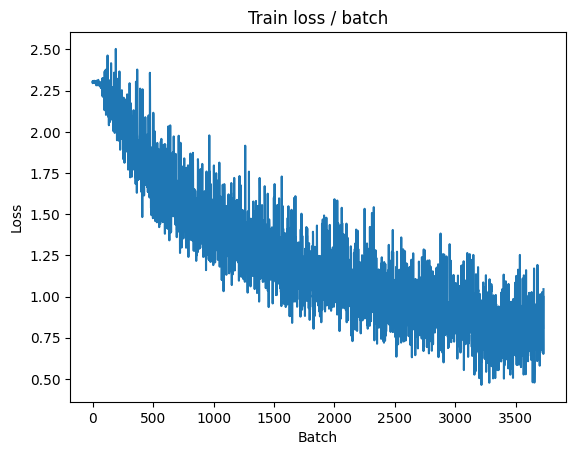


===============> Total time 12s	Avg loss 0.8038	Avg Prec@1 71.85 %	Avg Prec@5 98.00 %

[EVAL Batch 000/157]	Time 0.115s (0.115s)	Loss 1.2517 (1.2517)	Prec@1  54.7 ( 54.7)	Prec@5  92.2 ( 92.2)

===============> Total time 2s	Avg loss 1.1141	Avg Prec@1 61.36 %	Avg Prec@5 95.21 %



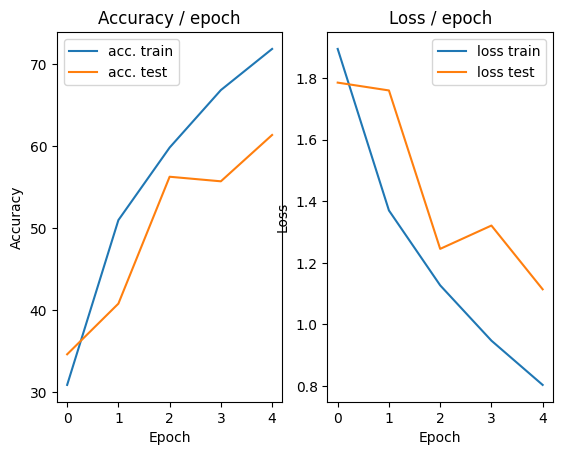

=== EPOCH 6 =====

[TRAIN Batch 000/782]	Time 0.137s (0.137s)	Loss 1.0182 (1.0182)	Prec@1  59.4 ( 59.4)	Prec@5 100.0 (100.0)


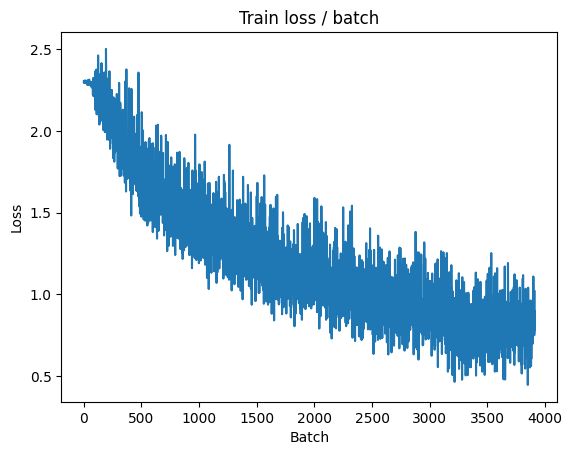

[TRAIN Batch 200/782]	Time 0.007s (0.015s)	Loss 0.9924 (0.6549)	Prec@1  62.5 ( 77.4)	Prec@5  96.9 ( 98.9)


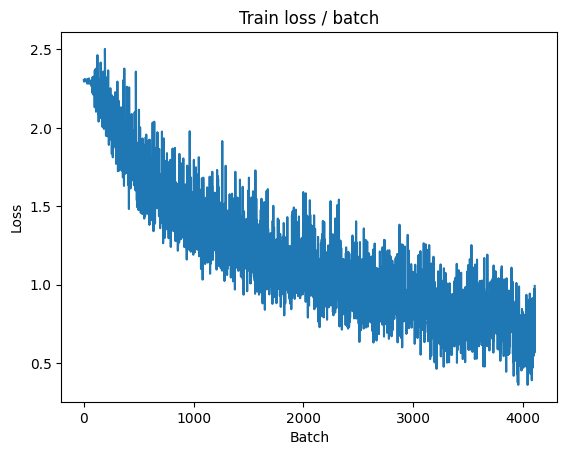

[TRAIN Batch 400/782]	Time 0.024s (0.015s)	Loss 0.7067 (0.6702)	Prec@1  70.3 ( 76.5)	Prec@5 100.0 ( 98.7)


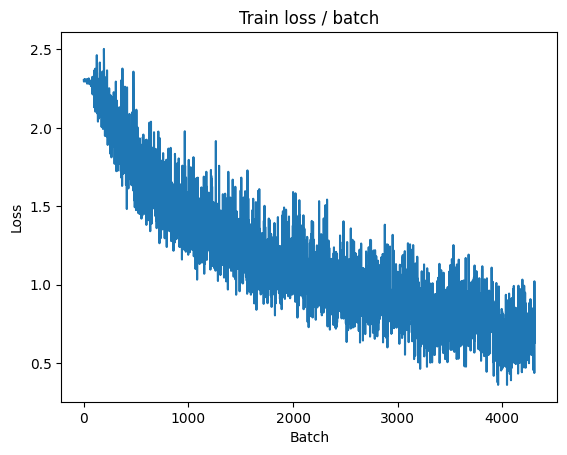

[TRAIN Batch 600/782]	Time 0.021s (0.015s)	Loss 1.0199 (0.6761)	Prec@1  68.8 ( 76.3)	Prec@5  93.8 ( 98.7)


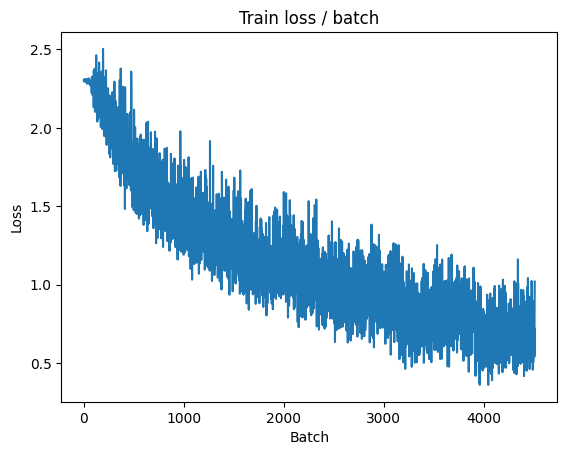


===============> Total time 12s	Avg loss 0.6756	Avg Prec@1 76.36 %	Avg Prec@5 98.69 %

[EVAL Batch 000/157]	Time 0.111s (0.111s)	Loss 1.2968 (1.2968)	Prec@1  60.9 ( 60.9)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.4564	Avg Prec@1 55.40 %	Avg Prec@5 95.16 %



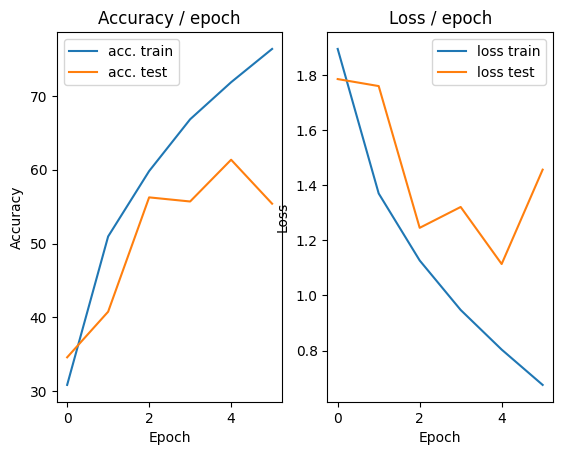

=== EPOCH 7 =====

[TRAIN Batch 000/782]	Time 0.151s (0.151s)	Loss 1.2156 (1.2156)	Prec@1  59.4 ( 59.4)	Prec@5  95.3 ( 95.3)


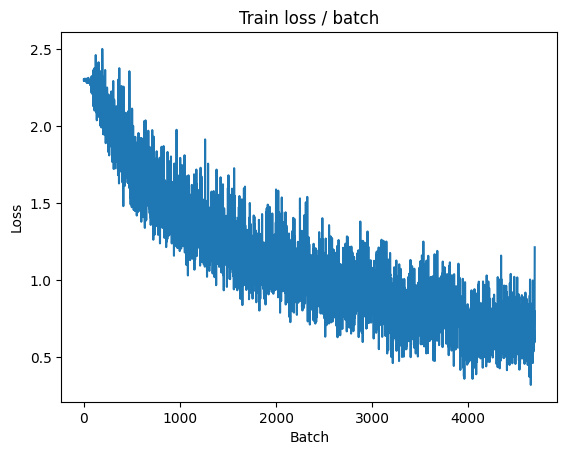

[TRAIN Batch 200/782]	Time 0.006s (0.015s)	Loss 0.4966 (0.5292)	Prec@1  82.8 ( 81.6)	Prec@5  98.4 ( 99.3)


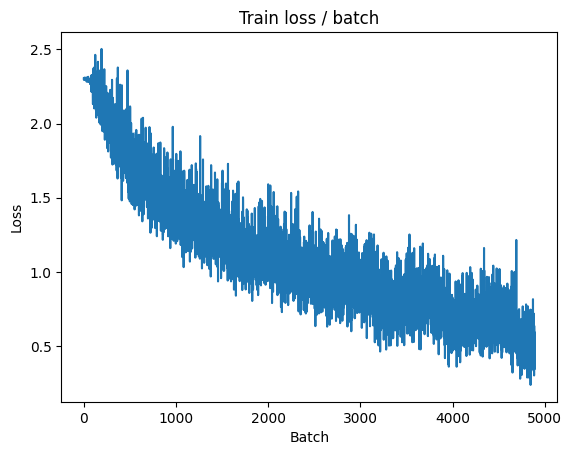

[TRAIN Batch 400/782]	Time 0.013s (0.015s)	Loss 0.4959 (0.5438)	Prec@1  79.7 ( 81.0)	Prec@5 100.0 ( 99.2)


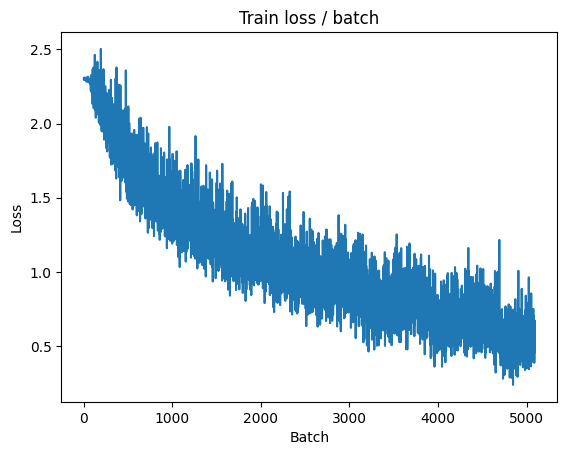

[TRAIN Batch 600/782]	Time 0.008s (0.017s)	Loss 0.4957 (0.5498)	Prec@1  82.8 ( 80.8)	Prec@5  98.4 ( 99.2)


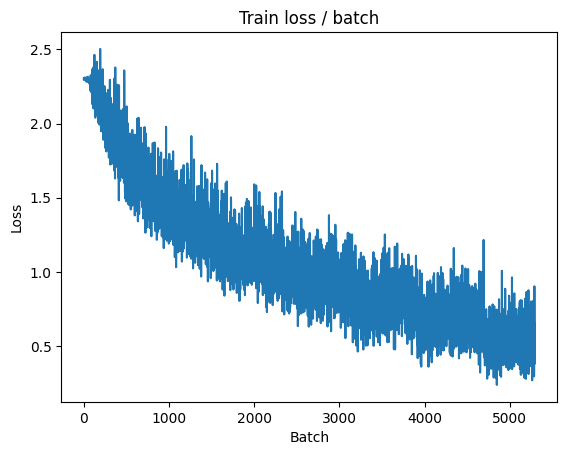


===============> Total time 12s	Avg loss 0.5535	Avg Prec@1 80.62 %	Avg Prec@5 99.20 %

[EVAL Batch 000/157]	Time 0.112s (0.112s)	Loss 0.8300 (0.8300)	Prec@1  71.9 ( 71.9)	Prec@5  98.4 ( 98.4)

===============> Total time 1s	Avg loss 0.9763	Avg Prec@1 68.64 %	Avg Prec@5 97.18 %



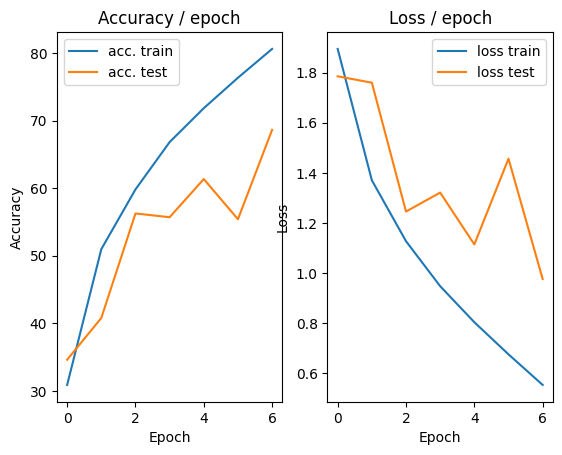

=== EPOCH 8 =====

[TRAIN Batch 000/782]	Time 0.140s (0.140s)	Loss 0.5742 (0.5742)	Prec@1  79.7 ( 79.7)	Prec@5  96.9 ( 96.9)


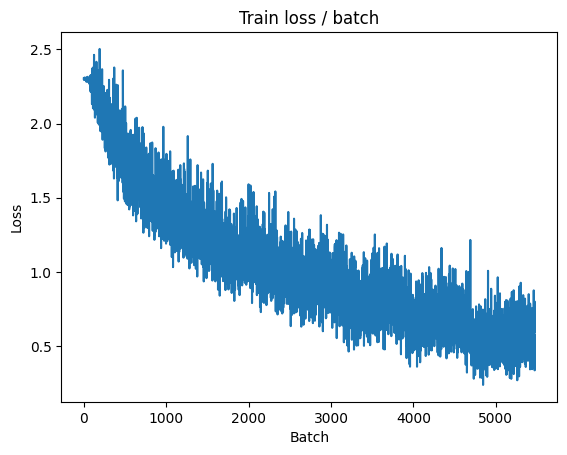

[TRAIN Batch 200/782]	Time 0.005s (0.015s)	Loss 0.3619 (0.4044)	Prec@1  84.4 ( 85.8)	Prec@5 100.0 ( 99.7)


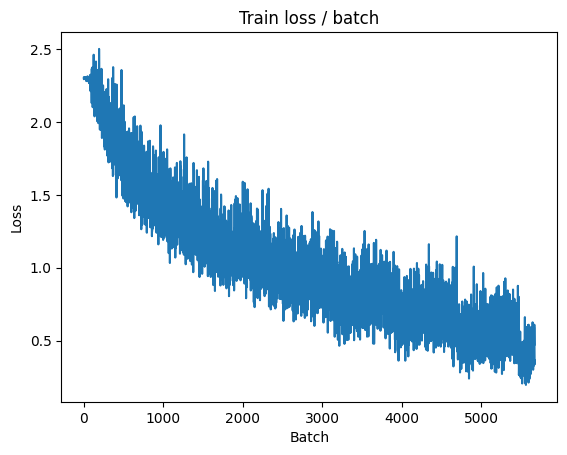

[TRAIN Batch 400/782]	Time 0.005s (0.016s)	Loss 0.3417 (0.4192)	Prec@1  89.1 ( 85.4)	Prec@5 100.0 ( 99.6)


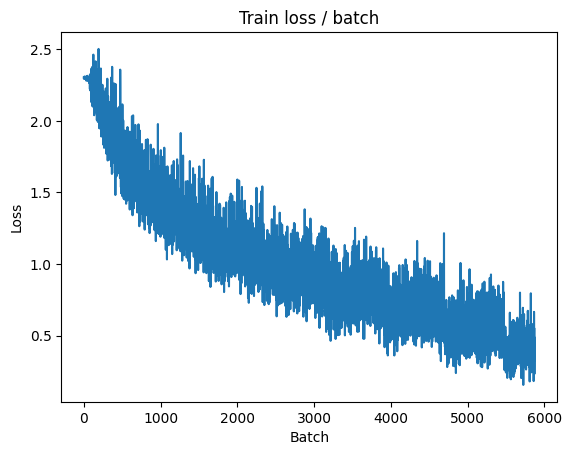

[TRAIN Batch 600/782]	Time 0.008s (0.017s)	Loss 0.3058 (0.4256)	Prec@1  90.6 ( 85.1)	Prec@5 100.0 ( 99.6)


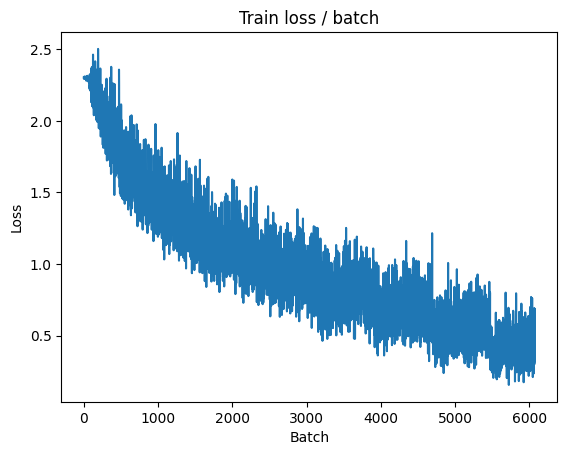


===============> Total time 12s	Avg loss 0.4350	Avg Prec@1 84.71 %	Avg Prec@5 99.60 %

[EVAL Batch 000/157]	Time 0.112s (0.112s)	Loss 0.7280 (0.7280)	Prec@1  82.8 ( 82.8)	Prec@5  98.4 ( 98.4)

===============> Total time 1s	Avg loss 0.9898	Avg Prec@1 69.33 %	Avg Prec@5 96.94 %



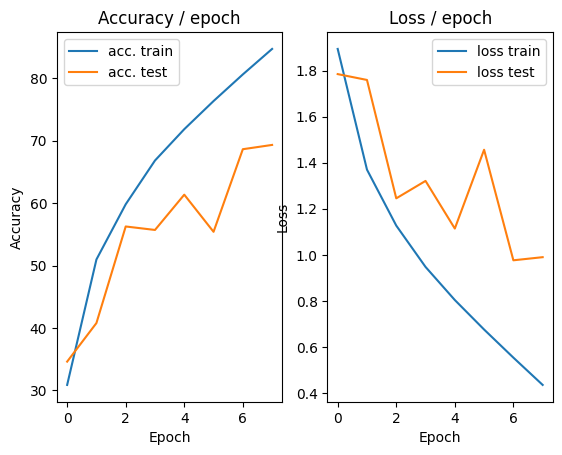

=== EPOCH 9 =====

[TRAIN Batch 000/782]	Time 0.142s (0.142s)	Loss 0.3687 (0.3687)	Prec@1  89.1 ( 89.1)	Prec@5 100.0 (100.0)


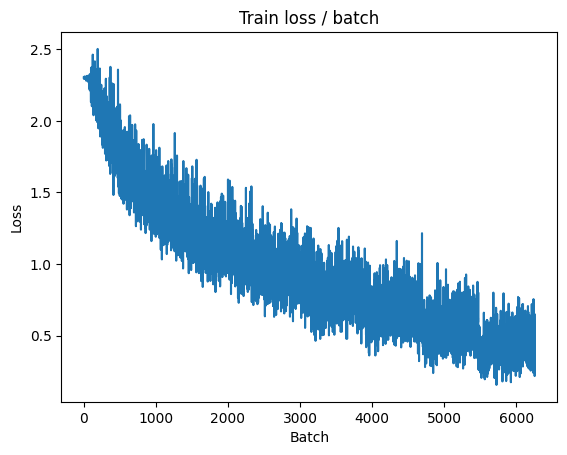

[TRAIN Batch 200/782]	Time 0.015s (0.015s)	Loss 0.3286 (0.2762)	Prec@1  85.9 ( 90.3)	Prec@5 100.0 ( 99.9)


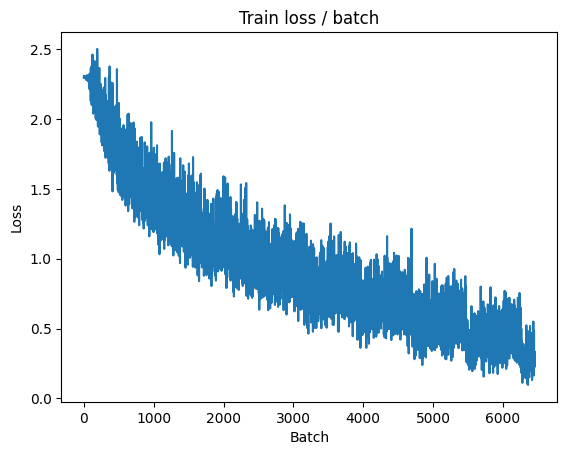

[TRAIN Batch 400/782]	Time 0.008s (0.018s)	Loss 0.4189 (0.3069)	Prec@1  85.9 ( 89.2)	Prec@5 100.0 ( 99.9)


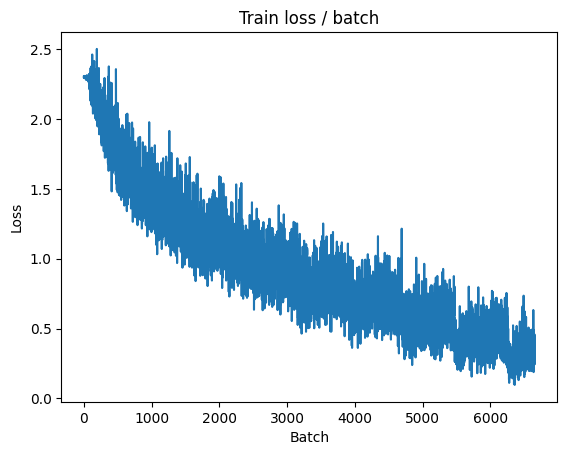

[TRAIN Batch 600/782]	Time 0.040s (0.018s)	Loss 0.1943 (0.3187)	Prec@1  90.6 ( 88.8)	Prec@5 100.0 ( 99.9)


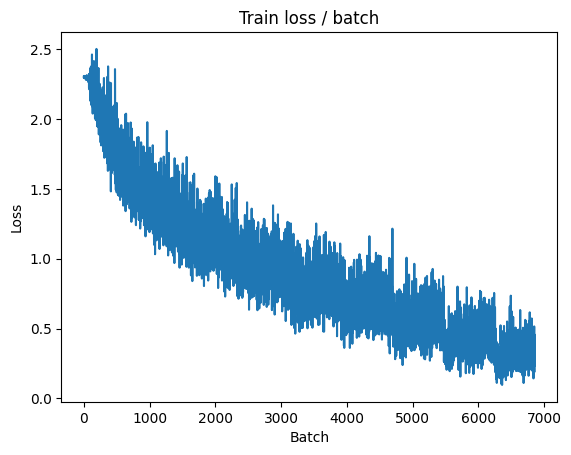


===============> Total time 13s	Avg loss 0.3343	Avg Prec@1 88.26 %	Avg Prec@5 99.82 %

[EVAL Batch 000/157]	Time 0.120s (0.120s)	Loss 0.7821 (0.7821)	Prec@1  73.4 ( 73.4)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.1160	Avg Prec@1 68.73 %	Avg Prec@5 97.06 %



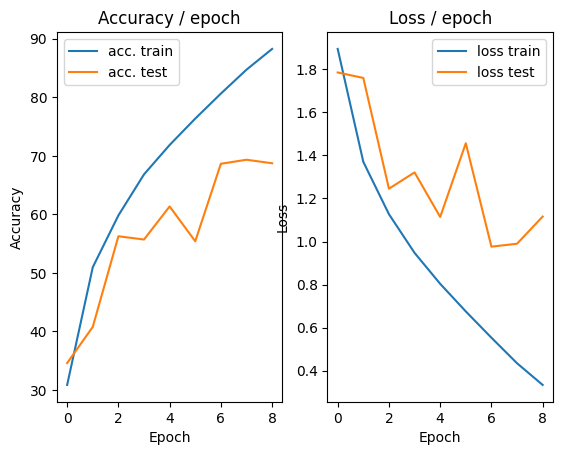

=== EPOCH 10 =====

[TRAIN Batch 000/782]	Time 0.182s (0.182s)	Loss 0.3660 (0.3660)	Prec@1  82.8 ( 82.8)	Prec@5 100.0 (100.0)


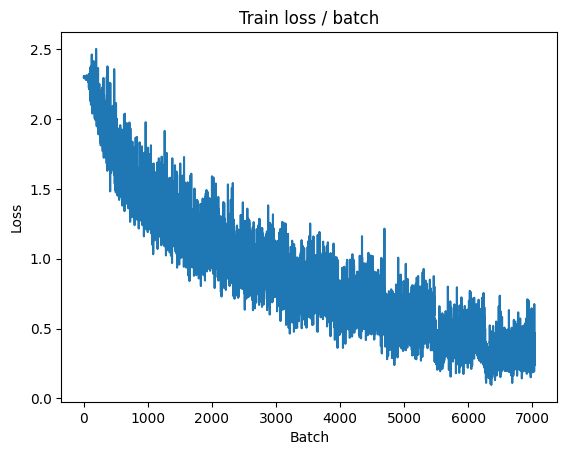

[TRAIN Batch 200/782]	Time 0.022s (0.020s)	Loss 0.2370 (0.2105)	Prec@1  85.9 ( 92.8)	Prec@5 100.0 ( 99.9)


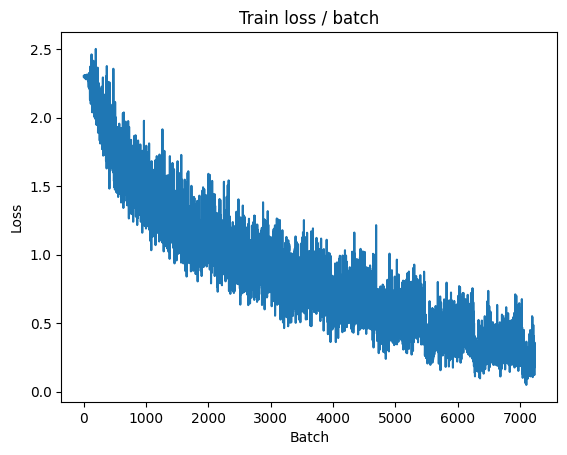

[TRAIN Batch 400/782]	Time 0.011s (0.017s)	Loss 0.3333 (0.2251)	Prec@1  87.5 ( 92.2)	Prec@5 100.0 ( 99.9)


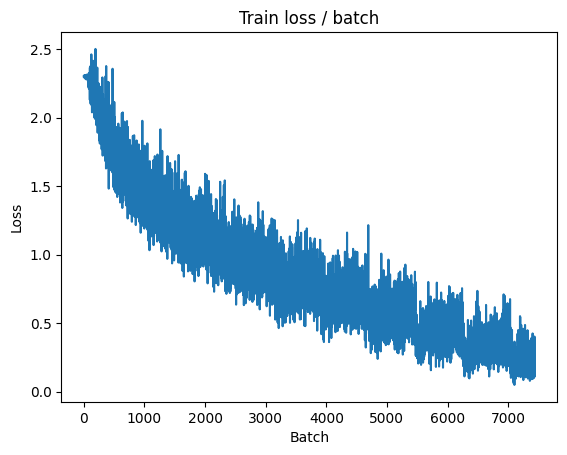

[TRAIN Batch 600/782]	Time 0.006s (0.016s)	Loss 0.1769 (0.2418)	Prec@1  93.8 ( 91.5)	Prec@5 100.0 ( 99.9)


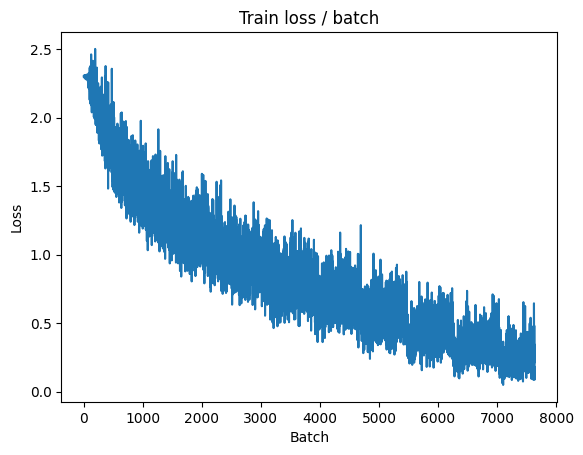


===============> Total time 12s	Avg loss 0.2543	Avg Prec@1 91.09 %	Avg Prec@5 99.92 %

[EVAL Batch 000/157]	Time 0.104s (0.104s)	Loss 1.7605 (1.7605)	Prec@1  64.1 ( 64.1)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 1.9171	Avg Prec@1 61.90 %	Avg Prec@5 96.27 %



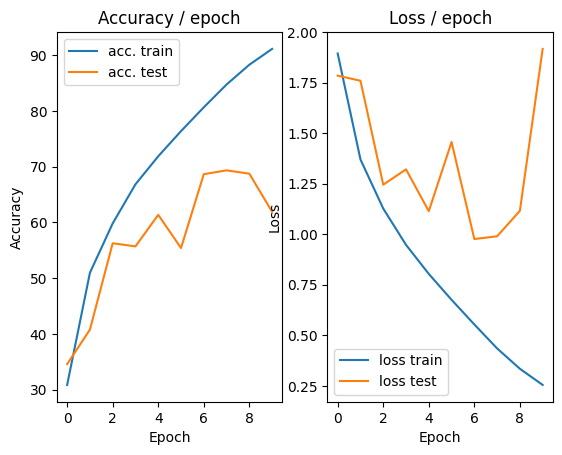

In [55]:
main(batch_size=64,lr=0.1,epochs=10,cuda=True)

- **Learning Rate**:

  - Effect on Convergence: The learning rate determines the step size at which the model's weights are updated during training. A high learning rate can lead to faster convergence, but it might also make the training process unstable, causing the loss to oscillate or diverge. Conversely, a very low learning rate may lead to very slow convergence and can get stuck in local minima.
  - Optimal Learning Rate: Finding the right learning rate is often a matter of experimentation. Techniques like learning rate schedules, learning rate annealing, or adaptive learning rates (e.g., Adam) can help adjust the learning rate during training to balance convergence speed and stability.
  - Regularization Effect: Higher learning rates can act as a form of regularization, helping to prevent overfitting to some extent by pushing the weights towards smaller values. This can be beneficial in some cases.

- **Batch Size**:

  - Effect on Training Time: The batch size determines how many training examples are used in each forward and backward pass. Larger batch sizes lead to faster training because they utilize parallelism and vectorization on hardware, but smaller batch sizes can provide more accurate updates to the model's weights.
  - Generalization vs. Speed: Smaller batch sizes tend to produce more accurate models because they provide a noisier gradient estimate in each iteration. This noise can have a regularizing effect, improving generalization. Larger batch sizes, on the other hand, can speed up training but might lead to worse generalization if overfitting is not controlled.
  - Memory and Hardware Constraints: Larger batch sizes require more memory and may not fit on some hardware, while smaller batch sizes are less memory-intensive and can be useful in scenarios where memory is limited.
  - Convergence Behavior: The batch size can influence the convergence behavior. In some cases, larger batch sizes may reach convergence with fewer epochs but at the cost of slower convergence within each epoch.

**Overfitting**: The primary issue is overfitting, which means the model has learned to fit the training data too closely, at the expense of generalization.

**Solutions**:
- Regularization: Use techniques like L1 or L2 regularization to constrain the model's weights and prevent overfitting.
- Dropout: Apply dropout during training, which randomly deactivates neurons, preventing them from over-relying on specific features.
- Early Stopping: Monitor the testing loss and stop training when it starts to increase, indicating that further training is detrimental.
- More Data: If possible, collect more training data to help the model generalize better.
